# DEA CoastLines vector statistics

## Background


## Description



## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [3]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import deacoastlines_statistics as dcl_stats

import os
import sys
import geopandas as gpd
from shapely.geometry import box
from rasterio.transform import array_bounds
import pandas as pd
import shutil
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_spatialtools import subpixel_contours

## Load in data

In [10]:
# Read in contours
study_area = 1194
output_name = 'v0.2.0'
water_index = 'mndwi'
index_threshold = 0.00
baseline_year = '2018'


## Load DEA CoastLines rasters

In [11]:
yearly_ds = dcl_stats.load_rasters(output_name, study_area, water_index)
print(yearly_ds)

# Create output vector folder
output_dir = f'output_data/{study_area}_{output_name}/vectors'
os.makedirs(f'{output_dir}/shapefiles', exist_ok=True)

<xarray.Dataset>
Dimensions:         (x: 1605, y: 2143, year: 31)
Coordinates:
  * x               (x) float64 3.603e+05 3.604e+05 ... 4.084e+05 4.084e+05
  * y               (y) float64 -3.5e+06 -3.5e+06 ... -3.564e+06 -3.564e+06
  * year            (year) int64 1988 1989 1990 1991 ... 2015 2016 2017 2018
Data variables:
    mndwi           (year, y, x) float32 0.46874997 0.3211679 ... -0.5345419
    gapfill_index   (year, y, x) float32 0.40928268 0.3290735 ... -0.5218923
    gapfill_tide_m  (year, y, x) float32 0.0034027584 ... -0.005190317
    gapfill_count   (year, y, x) int16 21 21 21 22 22 22 ... 57 57 55 54 54 55
    stdev           (year, y, x) float32 0.29117942 0.26207682 ... 0.13946061
    tide_m          (year, y, x) float32 0.0066862395 ... -0.0105146505
    count           (year, y, x) int16 11 11 11 11 11 11 ... 25 26 27 26 26 27
Attributes:
    crs:        +init=epsg:32650
    transform:  | 30.00, 0.00, 360315.00|\n| 0.00,-30.00,-3499755.00|\n| 0.00...


## Load vector data

In [12]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(box(*array_bounds(height=yearly_ds.sizes['y'],
                                       width=yearly_ds.sizes['x'],
                                       transform=yearly_ds.transform)),
                     crs=yearly_ds.crs)

# Rocky shore mask
smartline_gdf = (gpd.read_file('input_data/Smartline.gdb', 
                               bbox=bbox).to_crs(yearly_ds.crs))

# Tide points
points_gdf = (gpd.read_file('input_data/tide_points_coastal.geojson', 
                            bbox=bbox).to_crs(yearly_ds.crs))

# Study area polygon
comp_gdf = (gpd.read_file('input_data/50km_albers_grid_clipped.shp', bbox=bbox)
            .set_index('id')
            .to_crs(str(yearly_ds.crs)))

# Mask to study area
study_area_poly = comp_gdf.loc[study_area]

# Load climate indices
climate_df = pd.read_csv('input_data/climate_indices.csv', index_col='year')

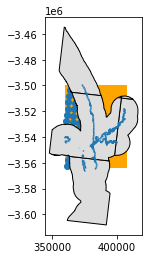

In [13]:
bbox.plot(facecolor='orange')
smartline_gdf.plot(ax=plt.gca())
points_gdf.plot(ax=plt.gca())
comp_gdf.plot(ax=plt.gca(), facecolor="#DDDDDD", edgecolor='black')

## Extract shoreline contours

### Extract ocean-masked contours

In [ ]:
# Generate waterbody mask
waterbody_array = dcl_stats.waterbody_mask(
    input_data='input_data/SurfaceHydrologyPolygonsRegional.gdb',
    modification_data='input_data/estuary_mask_modifications.geojson',
    bbox=bbox,
    yearly_ds=yearly_ds)

In [ ]:
# Mask dataset to focus on coastal zone only
masked_ds = dcl_stats.contours_preprocess(
    yearly_ds,
    water_index,
    index_threshold,
    waterbody_array,
    points_gdf,
    output_path=f'output_data/{study_area}_{output_name}')

In [ ]:
# Extract contours
contours_gdf = subpixel_contours(da=masked_ds,
                                 z_values=index_threshold,
                                 min_vertices=30,
                                 dim='year',
                                 output_path='temp.geojson').set_index('year')

## Compute statistics
### Create stats points on baseline contour

In [ ]:
# Extract statistics modelling points along baseline contour
points_gdf = dcl_stats.stats_points(contours_gdf, baseline_year, distance=30)

# Clip to remove rocky shoreline points
points_gdf = dcl_stats.rocky_shores_clip(points_gdf, smartline_gdf, buffer=50)


### Measure annual coastline movements

In [ ]:
if points_gdf is not None:
    
    # Make a copy of the points GeoDataFrame to hold tidal data
    tide_points_gdf = points_gdf.copy()

    # Calculate annual movements and residual tide heights for every contour
    # compared to the baseline year
    points_gdf, tide_points_gdf = dcl_stats.annual_movements(yearly_ds, 
                                                             points_gdf, 
                                                             tide_points_gdf, 
                                                             contours_gdf, 
                                                             baseline_year,
                                                             water_index)

In [ ]:
# points_gdf.plot(column='1988')

### Calculate regressions

In [ ]:
if points_gdf is not None:

    points_gdf = dcl_stats.calculate_regressions(yearly_ds, 
                                                 points_gdf, 
                                                 tide_points_gdf, 
                                                 climate_df)

## Export files

### Export stats files

In [ ]:
if points_gdf is not None:
    
    col_schema = [('rate_time', 'float:8.2'), ('rate_SOI', 'float:8.2'),
              ('rate_IOD', 'float:8.2'), ('rate_SAM', 'float:8.2'),
              ('rate_IPO', 'float:8.2'), ('rate_PDO', 'float:8.2'),
              ('rate_tide', 'float:8.2'), ('sig_time', 'float:8.3'),
              ('sig_SOI', 'float:8.3'), ('sig_IOD', 'float:8.3'),
              ('sig_SAM', 'float:8.3'), ('sig_IPO', 'float:8.3'),
              ('sig_PDO', 'float:8.3'), ('sig_tide', 'float:8.3'),
              ('outl_time', 'str:80'), ('outl_SOI', 'str:80'),
              ('outl_IOD', 'str:80'), ('outl_SAM', 'str:80'),
              ('outl_IPO', 'str:80'), ('outl_PDO', 'str:80'),
              ('outl_tide', 'str:80'), ('1988', 'float:8.2'),
              ('1989', 'float:8.2'), ('1990', 'float:8.2'),
              ('1991', 'float:8.2'), ('1992', 'float:8.2'),
              ('1993', 'float:8.2'), ('1994', 'float:8.2'),
              ('1995', 'float:8.2'), ('1996', 'float:8.2'),
              ('1997', 'float:8.2'), ('1998', 'float:8.2'),
              ('1999', 'float:8.2'), ('2000', 'float:8.2'),
              ('2001', 'float:8.2'), ('2002', 'float:8.2'),
              ('2003', 'float:8.2'), ('2004', 'float:8.2'),
              ('2005', 'float:8.2'), ('2006', 'float:8.2'),
              ('2007', 'float:8.2'), ('2008', 'float:8.2'),
              ('2009', 'float:8.2'), ('2010', 'float:8.2'),
              ('2011', 'float:8.2'), ('2012', 'float:8.2'),
              ('2013', 'float:8.2'), ('2014', 'float:8.2'),
              ('2015', 'float:8.2'), ('2016', 'float:8.2'),
              ('2017', 'float:8.2'), ('2018', 'float:8.2')]

    # Clip stats to study area extent, remove rocky shores
    stats_path = f'{output_dir}/stats_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
    points_gdf = points_gdf[points_gdf.intersects(study_area_poly['geometry'])]

    # Export to GeoJSON
    points_gdf.to_crs('EPSG:4326').to_file(f'{stats_path}.geojson', 
                                           driver='GeoJSON')

    # Export as ESRI shapefiles
    stats_path = stats_path.replace('vectors', 'vectors/shapefiles')
    points_gdf.to_file(f'{stats_path}.shp',
                       schema={'properties': col_schema,
                               'geometry': 'Point'})

In [ ]:
study_area_poly.plot()
points_gdf.plot(ax=plt.gca())

### Export contours

In [ ]:
# Assign certainty to contours based on underlying masks
contours_gdf = dcl_stats.contour_certainty(contours_gdf, 
                                           output_path=f'output_data/{study_area}_{output_name}')

# Clip annual shoreline contours to study area extent
contour_path = f'{output_dir}/contours_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
contours_gdf['geometry'] = contours_gdf.intersection(study_area_poly['geometry'])
contours_gdf.reset_index().to_crs('EPSG:4326').to_file(f'{contour_path}.geojson', 
                                                       driver='GeoJSON')

# Export stats and contours as ESRI shapefiles
contour_path = contour_path.replace('vectors', 'vectors/shapefiles')
contours_gdf.reset_index().to_file(f'{contour_path}.shp')

## Merge contours and rasters

In [ ]:
# Export coastlines
!ogrmerge.py -o DEACoastLines_coastlines_v0.2.0_0.10.shp output_data/*/vectors/shapefiles/contours_*_v0.2.0_mndwi_0.10.shp -single -overwrite_ds -t_srs EPSG:4326

In [ ]:
# Export statistics
!ogrmerge.py -o DEACoastLines_statistics_v0.2.0.shp output_data/*/vectors/shapefiles/stats_*_v0.2.0_mndwi_0.00.shp -single -overwrite_ds -t_srs EPSG:4326

In [ ]:
# Export mask
!gdalwarp output_data/*v0.2.0/all_time_mask.tif mask_v0.2.0.tif -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=1 -co TILED=YES -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024 -overwrite -q

In [ ]:
!gdalwarp output_data/*v0.2.0/1988_count.tif 1988_count.tif -co COMPRESS=DEFLATE -co ZLEVEL=5 -co PREDICTOR=1 -co TILED=YES -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024 -overwrite -q

In [ ]:
!gdalwarp output_data/*v0.2.0/2011_mndwi.tif 2011_mndwi.tif -co COMPRESS=DEFLATE -co ZLEVEL=5 -co PREDICTOR=1 -co TILED=YES -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024 -co BIGTIFF=YES -overwrite -q

In [ ]:
!gdaladdo -r average 1988_count.tif 16

## Generate continental summary layer

In [ ]:
from deacoastlines_summary import main

In [ ]:
main(['out', 'v0.2.0'])

## Assorted

In [ ]:
def gadi_su(memory, time, queue='normal'):
    
    if queue == 'normal':
        print((memory / 4) * 2 * time)
    if queue == 'hugemem':
        print((memory / 32) * 3 * time)
        
gadi_su(memory=96, time=6, queue='hugemem')        
        

In [ ]:
import geopandas as gpd

col_schema = [('rate_time', 'float:8.2'), ('rate_SOI', 'float:8.2'),
              ('rate_IOD', 'float:8.2'), ('rate_SAM', 'float:8.2'),
              ('rate_IPO', 'float:8.2'), ('rate_PDO', 'float:8.2'),
              ('rate_tide', 'float:8.2'), ('sig_time', 'float:8.3'),
              ('sig_SOI', 'float:8.3'), ('sig_IOD', 'float:8.3'),
              ('sig_SAM', 'float:8.3'), ('sig_IPO', 'float:8.3'),
              ('sig_PDO', 'float:8.3'), ('sig_tide', 'float:8.3'),
              ('outl_time', 'str:80'), ('outl_SOI', 'str:80'),
              ('outl_IOD', 'str:80'), ('outl_SAM', 'str:80'),
              ('outl_IPO', 'str:80'), ('outl_PDO', 'str:80'),
              ('outl_tide', 'str:80'), ('1988', 'float:8.2'),
              ('1989', 'float:8.2'), ('1990', 'float:8.2'),
              ('1991', 'float:8.2'), ('1992', 'float:8.2'),
              ('1993', 'float:8.2'), ('1994', 'float:8.2'),
              ('1995', 'float:8.2'), ('1996', 'float:8.2'),
              ('1997', 'float:8.2'), ('1998', 'float:8.2'),
              ('1999', 'float:8.2'), ('2000', 'float:8.2'),
              ('2001', 'float:8.2'), ('2002', 'float:8.2'),
              ('2003', 'float:8.2'), ('2004', 'float:8.2'),
              ('2005', 'float:8.2'), ('2006', 'float:8.2'),
              ('2007', 'float:8.2'), ('2008', 'float:8.2'),
              ('2009', 'float:8.2'), ('2010', 'float:8.2'),
              ('2011', 'float:8.2'), ('2012', 'float:8.2'),
              ('2013', 'float:8.2'), ('2014', 'float:8.2'),
              ('2015', 'float:8.2'), ('2016', 'float:8.2'),
              ('2017', 'float:8.2'), ('2018', 'float:8.2')]

fname=f'DEACoastLines_statistics_v0.2.0.shp'
stats_gdf = gpd.read_file(fname)
stats_gdf.to_file(f'DEACoastLines_statistics_v0.2.0_schema.shp', 
                  schema={'properties': col_schema, 
                          'geometry': 'Point'})


In [ ]:
import shutil
shutil.make_archive('DEACoastLines_v0.2.0', 'zip', '/g/data/r78/rt1527/dea-notebooks/MAHTS/packages/DEACoastLines_v0.2.0')


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2020